In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

In [155]:
df= pd.read_csv('../input/garlic/(lstm).csv',encoding='cp949')
df.head()

,date,ondo,sun,uga,price
0,2015-01-04,-1.3,8.16,52.125,5967
1,2015-01-05,0.0,7.30,50.980,5967
2,2015-01-06,1.0,10.72,48.080,5967
3,2015-01-07,-5.3,11.34,46.600,5967
4,2015-01-08,-6.5,11.84,47.500,5967


In [156]:
sun=df['sun']
ondo=df['ondo']
uga=df['uga']
price=df['price']
date=['date']

Text(0.5, 1.0, 'price')

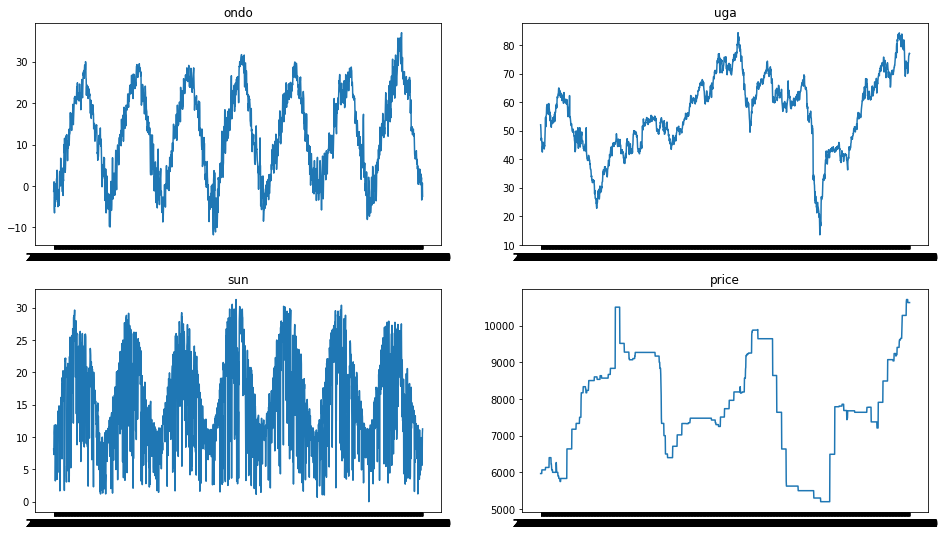

In [157]:
plt.figure(figsize=(16, 9))
plt.subplot(221)
plt.plot(df['date'], df['ondo'],label='ondo')
plt.title('ondo')

plt.subplot(222)
plt.plot(df['date'], df['uga'],label='uga')
plt.title('uga')

plt.subplot(223)
plt.plot(df['date'], df['sun'],label='sun')
plt.title('sun')

plt.subplot(224)
plt.plot(df['date'], df['price'],label='price')
plt.title('price')

In [158]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['uga', 'ondo', 'sun', 'price']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])
scaled

array([[0.54434574, 0.21516393, 0.26086957, 0.139252  ],
       [0.52820079, 0.24180328, 0.23337596, 0.139252  ],
       [0.48730964, 0.26229508, 0.342711  , 0.139252  ],
       ...,
       [0.89382403, 0.22336066, 0.1806266 , 0.98493101],
       [0.89847716, 0.25614754, 0.33727621, 0.98493101],
       [0.89678511, 0.19057377, 0.35997442, 0.98493101]])

In [159]:
df = pd.DataFrame(scaled, columns=scale_cols)
df

,uga,ondo,sun,price
0,0.544346,0.215164,0.260870,0.139252
1,0.528201,0.241803,0.233376,0.139252
2,0.487310,0.262295,0.342711,0.139252
3,0.466441,0.133197,0.362532,0.139252
4,0.479131,0.108607,0.378517,0.139252
...,...,...,...,...
1719,0.882685,0.172131,0.313939,0.984931
1720,0.887620,0.188525,0.317136,0.984931
1721,0.893824,0.223361,0.180627,0.984931
1722,0.898477,0.256148,0.337276,0.984931


In [160]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[['ondo', 'sun', 'uga']],df['price'],test_size=0.2, random_state=12, shuffle=False)

In [161]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1379, 3) (1379,)
(345, 3) (345,)


In [162]:
x_train

,ondo,sun,uga
0,0.215164,0.260870,0.544346
1,0.241803,0.233376,0.528201
2,0.262295,0.342711,0.487310
3,0.133197,0.362532,0.466441
4,0.108607,0.378517,0.479131
...,...,...,...
1374,0.784836,0.350064,0.408347
1375,0.805328,0.629156,0.415257
1376,0.793033,0.329604,0.426396
1377,0.782787,0.171355,0.425691


In [163]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [164]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [165]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [166]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Bidirectional,Dropout,BatchNormalization
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    Conv1D(filters=32, kernel_size=3,
           padding="causal",
           activation="relu"),
    Conv1D(filters=32, kernel_size=3,
           padding="causal",
           activation="relu"),
    # LSTM
    LSTM(16, activation='tanh',return_sequences = True),
    LSTM(32, activation='relu',return_sequences = True),
    Bidirectional(LSTM(64, activation='relu',return_sequences = True)),
    Bidirectional(LSTM(128, activation='relu',return_sequences = True)),
    Bidirectional(LSTM(256, activation='relu',return_sequences = False)),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [167]:
optimizer = Adam(0.0005)
model.compile(loss = Huber(), optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [168]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [169]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=200, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
43/43 [==============================] - 19s 283ms/step - loss: 0.0468 - root_mean_squared_error: 0.3060 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0610

Epoch 00001: val_loss improved from inf to 0.00186, saving model to tmp/ckeckpointer.ckpt
Epoch 2/200
43/43 [==============================] - 12s 273ms/step - loss: 0.0032 - root_mean_squared_error: 0.0795 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0508

Epoch 00002: val_loss improved from 0.00186 to 0.00129, saving model to tmp/ckeckpointer.ckpt
Epoch 3/200
43/43 [==============================] - 12s 267ms/step - loss: 0.0028 - root_mean_squared_error: 0.0750 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0702

Epoch 00003: val_loss did not improve from 0.00129
Epoch 4/200
43/43 [==============================] - 11s 263ms/step - loss: 0.0024 - root_mean_squared_error: 0.0687 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0501

Epoch 00004: val_loss improved from 0.00129 to 0.00125, saving mo

In [170]:
pred = model.predict(test_data)
pred.shape

(325, 1)

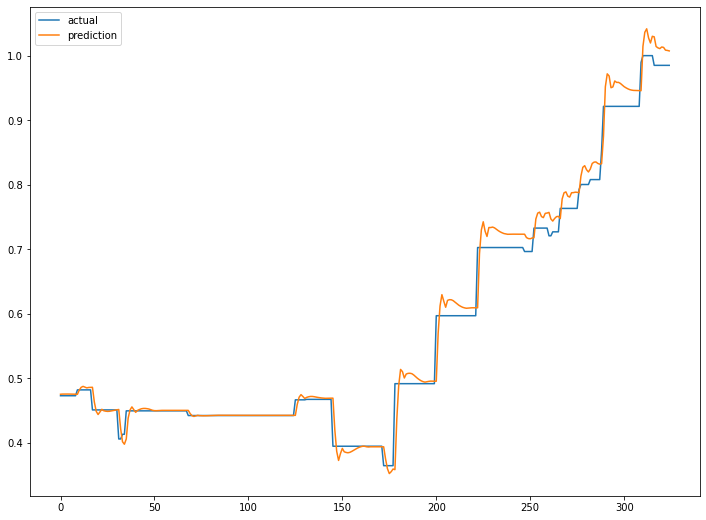

In [171]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [172]:
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()


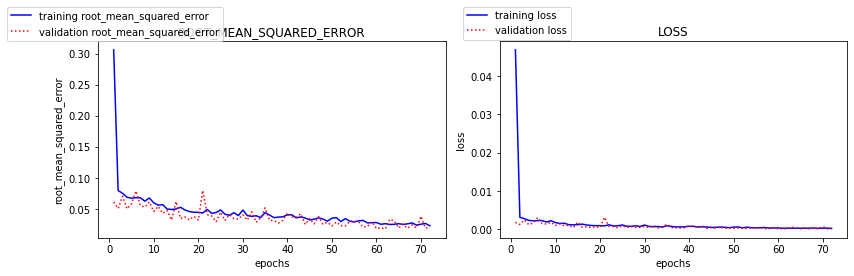

In [173]:
plot_history(history)

In [174]:
import tensorflow.keras as keras
x_test_t = x_test.values.reshape(x_test.shape[0], 3, 1)
y_test_t = y_test.values.reshape(y_test.shape[0], 1)
score=model.evaluate(x_test_t,y_test,batch_size=32)

11/11 [==============================] - 1s 7ms/step - loss: 0.0978 - root_mean_squared_error: 0.4422


In [175]:
model.save('garlic(lstm)1.h5')

Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

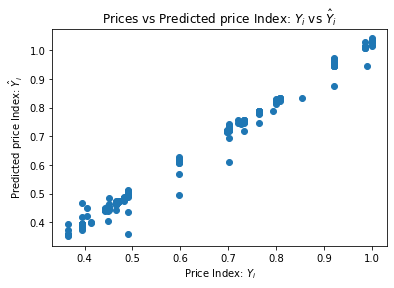

In [176]:
%matplotlib inline
import matplotlib.pyplot as plt


y_pred = model.predict(train_data, batch_size=32)
plt.scatter(y_test[20:], pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")


In [177]:
pred1 = pd.DataFrame(pred)
y_test1=y_test[20:]
y_test1 = pd.DataFrame(y_test1)
intergarlic=pd.concat([pred1,y_test1],axis=1)
intergarlic.to_csv('intergarlic(garlic).csv', index=False)